图片缩放与插值算法
===

# 1.最近邻域插值算法(Nearest-neighbor Interpolation)
假设原图片为src，目标图片为dst，那么就有
$$\begin{cases}
dstX&=srcX \times \frac{srcH}{dstH} \\
dstY&=srcY \times \frac{srcW}{dstW}
\end{cases}$$

最近邻插值在图像放大时补充的像素取最临近的像素的值。由于方法简单(采用了浮点数四舍五入)，所以处理速度很快，但是放大图像画质劣化明显。

# 2.双线性插值算法

双线性插值考察4邻域的像素点，并根据距离设置权值。虽然计算量增大使得处理时间变长，但是可以有效抑制画质劣化。双线性插值是图像缩放的一种方式，其主要分为两步线性插值，一是在x方向插值，二是用x方向插值结果再在y方向插值，具体步骤如下：

## 2.1.定位像素点

1. 先找到目标图像像素点$(dst_x, dst_y)$在源图像上的像素点位置$(src_x, src_y)$。一般是使用直接缩放：
$$src_x=dst_x * scale_x$$
而我们这里使用几何中心对称：
$$src_x = (dst_x + 0.5) * scale_x - 0.5$$
2. 然后找到上下左右最近邻的四个像素点用于计算插值。

## 2.2.两步插值

设$(x,y)$为插值点在源图像的坐标，待计算插值为$z$

1. 首先在$x$方向上插值：相邻两点为$(x_0,y_0)(x_1,y_0)$，像素值分别为$z_0=f(x_0,y_0)$与$z_1=f(x_1,y_0)$，从而有公式：$\frac{z−z_0}{x−x_0}=\frac{z_1−z_0}{x_1−x_0}$，从而插值$z=\frac{x_1−x}{x_1−x_0}z_0+\frac{x−x_0}{x_1−x_0}z_1$
2. 然后$y$方向上插值：以上得到的上方插值$z$记为$z_{top}$，同理可得下方插值为$z_{bot}$，那么最后插值为：$Z=\frac{y_1−y}{y_1−y_0}z_{top}+\frac{y−y_0}{y_1−y_0}z_{bot}$

![images](Images/01/09/04_001.png)

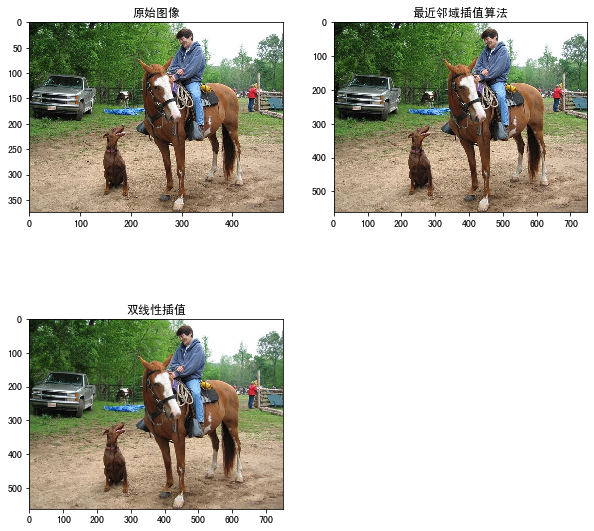

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

ratio = 1.5
image = cv2.imread("Images/01/09/02.jpg", 1)

def Interpo(img):
    shapes = img.shape
    height = shapes[0]
    width = shapes[1]
    dst_height = int(height * ratio)
    dst_width = int(width * ratio)
    dst_image = np.zeros((dst_height, dst_width, 3), dtype=np.uint8)

    for x in range(0, dst_height):
        for y in range(0, dst_width):
            dst_X = int(x * (height * 1.0 / dst_height))
            dst_Y = int(y * (width * 1.0 / dst_width))
            dst_image[x, y] = image[dst_X, dst_Y]
    return dst_image

def nn_interpolate(img):
    shapes = img.shape
    height = shapes[0]
    width = shapes[1]
    
    dst_w, dst_h = int(width * ratio), int(height * ratio)
    src_h, src_w = height, width
    if src_h == dst_h and src_w == dst_w:
        return img.copy()
    scale_x = float(src_w) / dst_w
    scale_y = float(src_h) / dst_h

    dst = np.zeros((dst_h, dst_w, 3), dtype=np.uint8)
    for n in range(3):
        for dst_y in range(dst_h):
            for dst_x in range(dst_w):

                src_x = (dst_x + 0.5) * scale_x - 0.5
                src_y = (dst_y + 0.5) * scale_y - 0.5

                src_x_0 = int(np.floor(src_x))
                src_y_0 = int(np.floor(src_y))
                src_x_1 = min(src_x_0 + 1, src_w - 1)
                src_y_1 = min(src_y_0 + 1, src_h - 1)

                value0 = (src_x_1 - src_x) * img[src_y_0, src_x_0, n] + (src_x - src_x_0) * img[src_y_0, src_x_1, n]
                value1 = (src_x_1 - src_x) * img[src_y_1, src_x_0, n] + (src_x - src_x_0) * img[src_y_1, src_x_1, n]
                dst[dst_y, dst_x, n] = int((src_y_1 - src_y) * value0 + (src_y - src_y_0) * value1)
    return dst

def bc_interpolate(img, ax=1., ay=1.):
	H, W, C = img.shape

	aH = int(ay * H)
	aW = int(ax * W)

	# get positions of resized image
	y = np.arange(aH).repeat(aW).reshape(aW, -1)
	x = np.tile(np.arange(aW), (aH, 1))
	y = (y / ay)
	x = (x / ax)

	# get positions of original image
	ix = np.floor(x).astype(np.int)
	iy = np.floor(y).astype(np.int)

	ix = np.minimum(ix, W-1)
	iy = np.minimum(iy, H-1)

	# get distance of each position of original image
	dx2 = x - ix
	dy2 = y - iy
	dx1 = dx2 + 1
	dy1 = dy2 + 1
	dx3 = 1 - dx2
	dy3 = 1 - dy2
	dx4 = 1 + dx3
	dy4 = 1 + dy3

	dxs = [dx1, dx2, dx3, dx4]
	dys = [dy1, dy2, dy3, dy4]

	# bi-cubic weight
	def weight(t):
		a = -1.
		at = np.abs(t)
		w = np.zeros_like(t)
		ind = np.where(at <= 1)
		w[ind] = ((a+2) * np.power(at, 3) - (a+3) * np.power(at, 2) + 1)[ind]
		ind = np.where((at > 1) & (at <= 2))
		w[ind] = (a*np.power(at, 3) - 5*a*np.power(at, 2) + 8*a*at - 4*a)[ind]
		return w

	w_sum = np.zeros((aH, aW, C), dtype=np.float32)
	out = np.zeros((aH, aW, C), dtype=np.float32)

	# interpolate
	for j in range(-1, 3):
		for i in range(-1, 3):
			ind_x = np.minimum(np.maximum(ix + i, 0), W-1)
			ind_y = np.minimum(np.maximum(iy + j, 0), H-1)

			wx = weight(dxs[i+1])
			wy = weight(dys[j+1])
			wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
			wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)

			w_sum += wx * wy
			out += wx * wy * img[ind_y, ind_x]

	out /= w_sum
	out = np.clip(out, 0, 255)
	out = out.astype(np.uint8)

	return out

plt.figure(figsize=(10,10), facecolor='w')
plt.subplot(2, 2, 1)
plt.title(u"原始图像")
show_img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img1)

plt.subplot(2, 2, 2)
plt.title(u"最近邻域插值算法")
show_img2 = cv2.cvtColor(Interpo(image), cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

plt.subplot(2, 2, 3)
plt.title(u"双线性插值")
show_img2 = cv2.cvtColor(nn_interpolate(image), cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

plt.subplot(2, 2, 4)
plt.title(u"双三次插值")
show_img2 = cv2.cvtColor(nn_interpolate(image), cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)